In [6]:
from fastai.vision import *

In [7]:
celebrities = ['valerie_dominguez',
           'sofia_vergara',
           'isabella_santo_domingo',
           'shakira']

# Folder where we'll store celebrity photos
path = Path('photos')

In [8]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

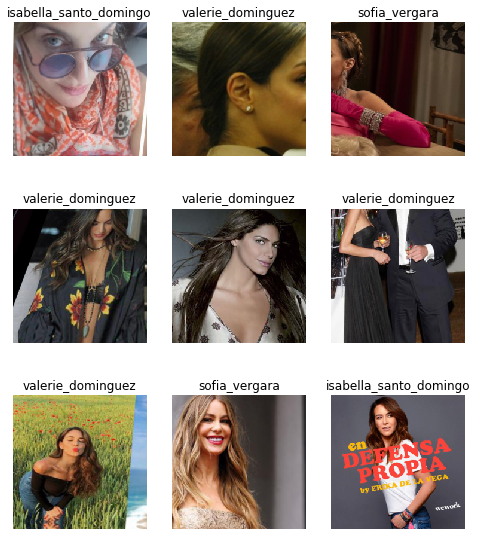

In [9]:
data.show_batch(rows=3, figsize=(7,8))

In [10]:
print(f'Categories for classification: \n{data.classes}\n')
print(f'Number of categories: {data.c}')
print(f'Length of training dataset: {len(data.train_ds)}')
print(f'Length of validation dataset: {len(data.valid_ds)}')

Categories for classification: 
['isabella_santo_domingo', 'shakira', 'sofia_vergara', 'valerie_dominguez']

Number of categories: 4
Length of training dataset: 607
Length of validation dataset: 151


In [11]:
# Define a new learner, based on the pre-trained ResNet34 CNN
learn = cnn_learner(data, models.resnet34, metrics=error_rate)
learn

Learner(data=ImageDataBunch;

Train: LabelList (607 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
valerie_dominguez,valerie_dominguez,valerie_dominguez,valerie_dominguez,valerie_dominguez
Path: photos;

Valid: LabelList (151 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
isabella_santo_domingo,valerie_dominguez,shakira,isabella_santo_domingo,isabella_santo_domingo
Path: photos;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=

In [ ]:
# Train the last couple of layers that are added fresh to the CNN during creation
learn.fit_one_cycle(4)

Note how the error rate started around 50%, and went down to 28%.

In [21]:
learn.save('stage-1')

In [22]:
# Now let's actually unfreeze the whole CNN, not just the last 
# couple of layers that were added automatically.
learn.unfreeze()

In [23]:
# Learning rate finder
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


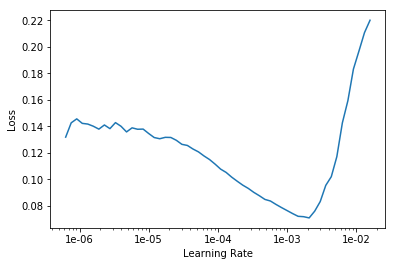

In [13]:
learn.recorder.plot()

In [24]:
# I choose a range that ends about one order of magnitude before the bottom of the 
# valley, and starts one order of magnitude before that.
# fit_one_cycle will apply a larger learning rate to later layers.
learn.fit_one_cycle(3, max_lr=slice(2e-5,2e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.580878,0.753866,0.288591,00:08
1,0.499145,0.721011,0.275168,00:08
2,0.442833,0.672826,0.261745,00:08


In [25]:
learn.save('stage-2')

In [26]:
learn.fit_one_cycle(5, max_lr=slice(2e-5,2e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.350587,0.635640,0.248322,00:08
1,0.317361,0.542940,0.208054,00:08
2,0.276076,0.571321,0.214765,00:08
3,0.238039,0.561260,0.194631,00:08
4,0.210249,0.562100,0.187919,00:08


In [32]:
learn.save('stage-3')

Down to 18% error rate!

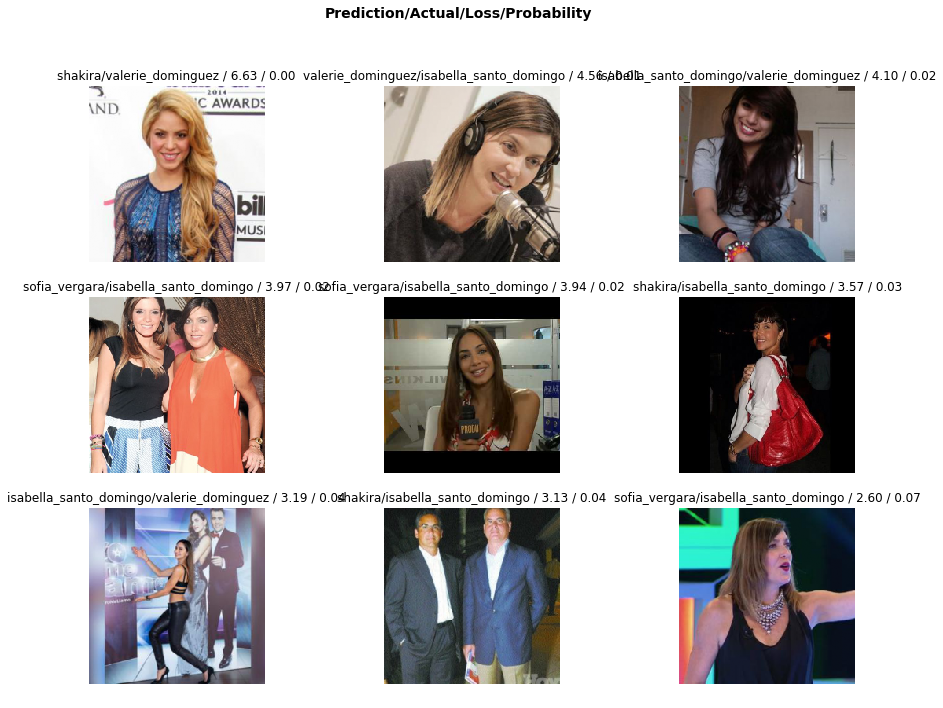

In [27]:
# Let's look at the images with the top losses from our model, to start
# seeing the problems with our data
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(15,11))

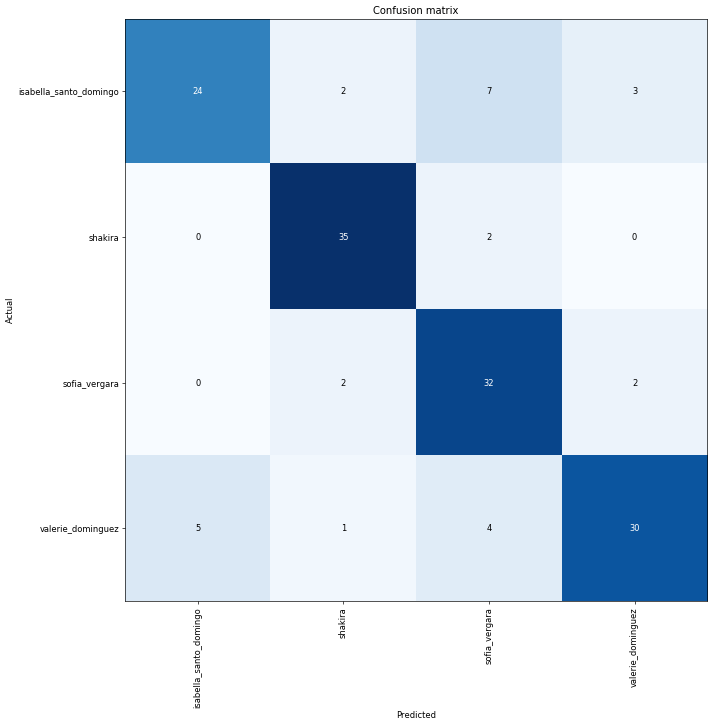

In [28]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

# Cleaning bad pics
The results above aren't half bad, but there's some problematic images.  At least one of the images labeled as Valeries Dominguez is clearly Shakira, for example.  Let's clean them up.

In [29]:
from fastai.widgets import *

In [31]:
# We'll make a new dataset that combines train+test again
db = (ImageList.from_folder(path)
                   .split_none()
                   .label_from_folder()
                   .transform(get_transforms(), size=224)
                   .databunch()
     )

In [34]:
# Re-create the learner with the new dataset, and import the weights
# that we got from training.
learn_cln = cnn_learner(db, models.resnet34, metrics=error_rate)

learn_cln.load('stage-3');

In [35]:
# Retrieve the indexes of the images with the greatest loss values
ds, idxs = DatasetFormatter().from_toplosses(learn_cln)

In [36]:
# Let's use a widget to clean the bad images.
ImageCleaner(ds, idxs, path)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

In [37]:
# Now clean up duplicate images
ds, idxs = DatasetFormatter().from_similars(learn_cln)

Getting activations...


Computing similarities...


In [38]:
ImageCleaner(ds, idxs, path, duplicates=True)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

In [39]:
# Recreate the data bunch from cleaned data
np.random.seed(42)
data = ImageDataBunch.from_csv(path, folder=".", valid_pct=0.2, csv_labels='cleaned.csv',
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [40]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['isabella_santo_domingo', 'shakira', 'sofia_vergara', 'valerie_dominguez'],
 4,
 587,
 146)

In [41]:
# Make the learner yet again
learn = cnn_learner(data, models.resnet34, metrics=error_rate)
# Add in the trained values
learn.load('stage-3');

In [42]:
# Train some more, for good measure
learn.fit_one_cycle(5, max_lr=slice(2e-5,2e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.306861,0.142605,0.027397,00:07
1,0.285120,0.142855,0.041096,00:07
2,0.285363,0.145032,0.041096,00:07
3,0.282988,0.142764,0.027397,00:07
4,0.266847,0.146651,0.041096,00:06


Down to 4% error rate!

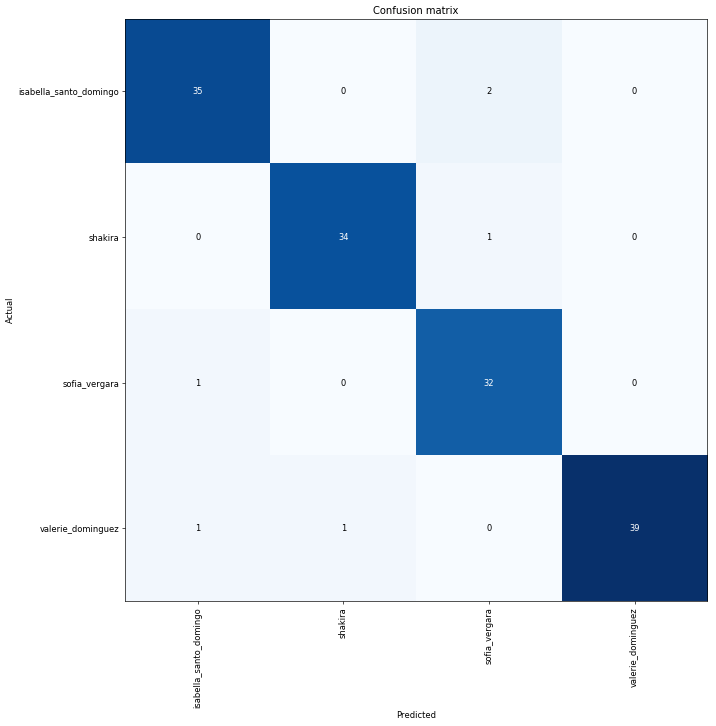

In [44]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

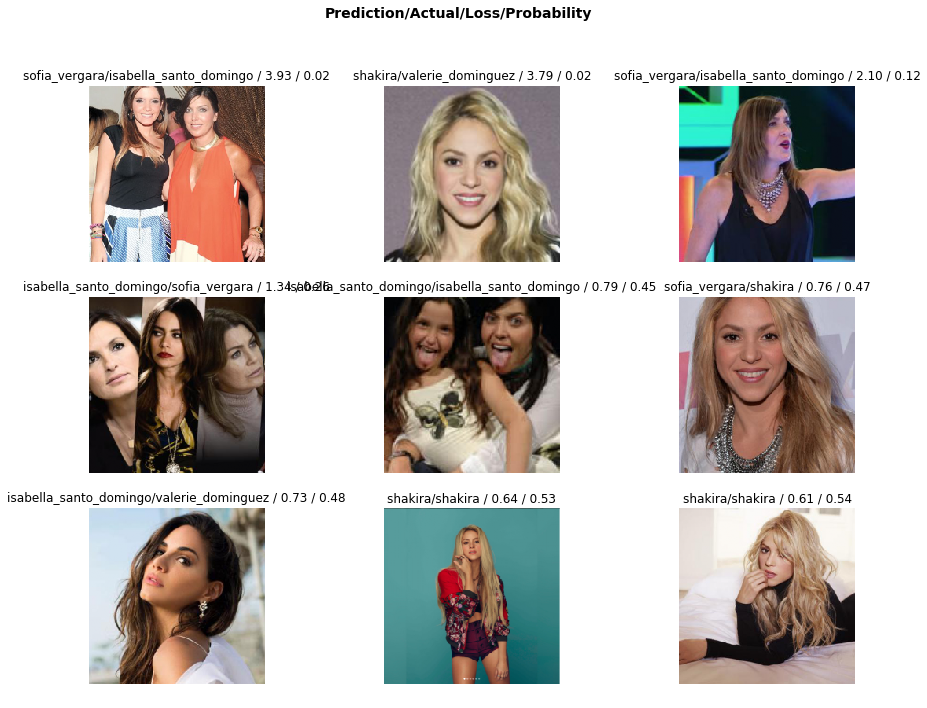

In [45]:
interp.plot_top_losses(9, figsize=(15,11))

Note how we've almost run out of actual errors (the last couple of predictions are correct, just not totally confident).  And even among the errors, there's at least one more mis-labeled image of Shakira.  Our model works!